In [1]:
import numpy as np
import pandas as pd
import pickle
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from forecast_evaluation import R2OS
from forecast_methods import HA_combination
import matplotlib.pyplot as plt

data_stocks = pd.read_csv('data_stocks.csv')
data_returns = pd.read_csv('data_return.csv')

returns = np.array(data_returns)[360:1080]

X = np.array(data_stocks.drop(columns=['yyyymm', 'EQPREM']))
y = np.array(data_stocks.loc[:,['EQPREM']]).flatten()

X_train = X[0:360,:]
X_test = X[360:1080,:]
y_train = y[0:360]
y_test = y[360:1080]


### Data - Descriptive Statistics

In [11]:
data_stocks = pd.read_csv('data_stocks.csv')

print(data_stocks.drop(columns=['yyyymm']).describe().T.to_latex())

\begin{tabular}{lrrrrrrrr}
\toprule
{} &   count &      mean &       std &       min &       25\% &       50\% &       75\% &       max \\
\midrule
EQPREM &  1080.0 &  0.005052 &  0.054502 & -0.339221 & -0.020066 &  0.009416 &  0.034981 &  0.346243 \\
DP     &  1080.0 & -3.365963 &  0.460030 & -4.523640 & -3.584079 & -3.338036 & -3.023517 & -1.873246 \\
DY     &  1080.0 & -3.361231 &  0.458045 & -4.530894 & -3.583574 & -3.332392 & -3.020019 & -1.912904 \\
EP     &  1080.0 & -2.732454 &  0.416647 & -4.836482 & -2.939130 & -2.785351 & -2.458990 & -1.774952 \\
SVAR   &  1080.0 &  0.002887 &  0.005777 &  0.000072 &  0.000705 &  0.001267 &  0.002453 &  0.070945 \\
BM     &  1080.0 &  0.571922 &  0.265128 &  0.120510 &  0.346138 &  0.546952 &  0.751562 &  2.028478 \\
NTIS   &  1080.0 &  0.017616 &  0.025549 & -0.055954 &  0.006365 &  0.017275 &  0.027534 &  0.177040 \\
TBL    &  1080.0 &  0.034343 &  0.031039 &  0.000100 &  0.003800 &  0.030000 &  0.051825 &  0.163000 \\
LTR    &  1080.0 &  

C:\Users\berma\AppData\Local\Temp\ipykernel_5820\373345350.py:3: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(data_stocks.drop(columns=['yyyymm']).describe().T.to_latex())


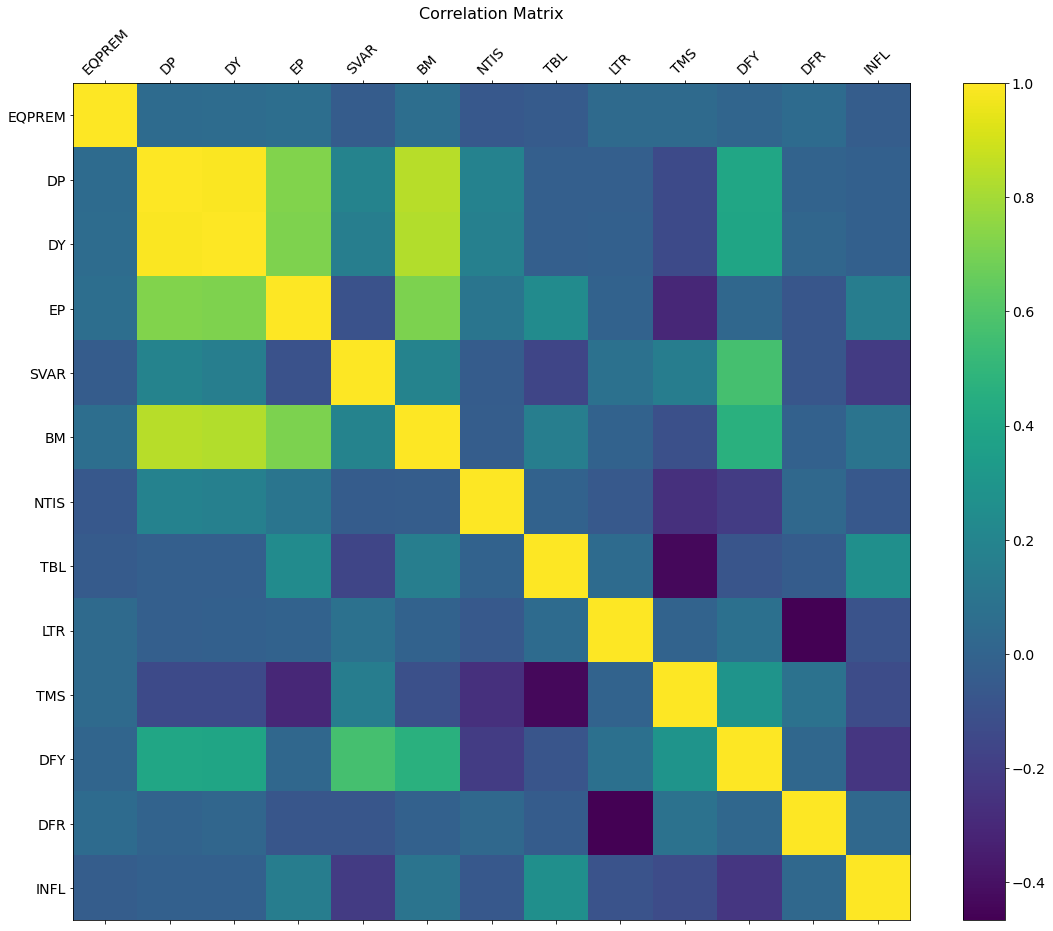

In [15]:
data_stocks = pd.read_csv('data_stocks.csv')

df = data_stocks.drop(columns=['yyyymm'])

f = plt.figure(figsize=(19, 15))
plt.matshow(df.corr(), fignum=f.number)
plt.xticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=14, rotation=45)
plt.yticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16)
plt.savefig('correlation_matrix')

### Extreme Returns

In [6]:
def R2OS_stdreturn(pred_model, y_train, y_test, returns):
    y_scaler = StandardScaler().fit(returns.reshape(-1,1))
    y_std = y_scaler.transform(returns.reshape(-1,1))
    
    n_periods = len(y_test)
    
    moderate = []
    
    abs_geq_1 = []
    abs_geq_2 = []
    abs_geq_3 = []
    abs_geq_4 = []
    
    geq1 = []
    geq2 = []
    geq3 = []
    geq4 = []
    
    leq_1 = []
    leq_2 = []
    leq_3 = []
    leq_4 = []
    
    pred_bmk = np.zeros((n_periods,))
    
    for i in range(n_periods):
        y_bmk = np.hstack([y_train, y_test[:i]])
        pred_bmk[i] = np.mean(y_bmk)
        
    for i in range(n_periods):
        
        absret = np.abs(y_std[i])
        ret = y_std[i]
        
        # check for moderate absolute values
        if 0 <= absret < 0.5:
            moderate.append({'real': y_test[i], 'model': pred_model[i], 'bmk': pred_bmk[i]})
        
        # check for extreme absolute values
        if 0.5 <= absret < 1.0:
            abs_geq_1.append({'real': y_test[i], 'model': pred_model[i], 'bmk': pred_bmk[i]})
        elif 1.0 <= absret < 1.5:
            abs_geq_2.append({'real': y_test[i], 'model': pred_model[i], 'bmk': pred_bmk[i]})
        elif 1.5 <= absret < 2.0:
            abs_geq_3.append({'real': y_test[i], 'model': pred_model[i], 'bmk': pred_bmk[i]})
        elif 2.0 <= absret:
            abs_geq_4.append({'real': y_test[i], 'model': pred_model[i], 'bmk': pred_bmk[i]})
        
        # check for extreme rise
        if 0.5 <= ret < 1.0:
            geq1.append({'real': y_test[i], 'model': pred_model[i], 'bmk': pred_bmk[i]})
        elif 1.0 <= ret < 1.5:
            geq2.append({'real': y_test[i], 'model': pred_model[i], 'bmk': pred_bmk[i]})
        elif 1.5 <= ret < 2.0:
            geq3.append({'real': y_test[i], 'model': pred_model[i], 'bmk': pred_bmk[i]})
        elif  2.0 <= ret:
            geq4.append({'real': y_test[i], 'model': pred_model[i], 'bmk': pred_bmk[i]})
        
        # check for extreme downturns
        if -1.0 < ret <= -0.5:
            leq_1.append({'real': y_test[i], 'model': pred_model[i], 'bmk': pred_bmk[i]})
        elif -1.5 < ret <= -1.0:
            leq_2.append({'real': y_test[i], 'model': pred_model[i], 'bmk': pred_bmk[i]})
        elif -2.0 < ret <= -1.5:
            leq_3.append({'real': y_test[i], 'model': pred_model[i], 'bmk': pred_bmk[i]})
        elif  ret < -2.0:
            leq_4.append({'real': y_test[i], 'model': pred_model[i], 'bmk': pred_bmk[i]})

    
    def calc_r2(res_lst):
        n = len(res_lst)
        model = np.zeros((n,))
        bmk = np.zeros((n,))
        real = np.zeros((n,))
        for i in range(n):
            model[i] = res_lst[i]['model']
            bmk[i] = res_lst[i]['bmk']
            real[i] = res_lst[i]['real']
        MSFE_M = metrics.mean_squared_error(model, real)
        MSFE_bmk = metrics.mean_squared_error(bmk, real)
        return R2OS(MSFE_M, MSFE_bmk)

    
    print('------------------------------------------------')
    print('Moderate Normalized Returns')
    print('------------------------------------------------')
    
    print('')
    print('Observations')
    print(f'{len(moderate)}/{n_periods}')
    
    print('')
    
    print('R2OS')
    print(calc_r2(moderate))
    
    print('')
    
    print('------------------------------------------------')
    print('Extreme Absolute Returns')
    print('------------------------------------------------')
    
    print('')
    
    print('Observations')
    print(f'{len(abs_geq_1)}/{n_periods}')
    print(f'{len(abs_geq_2)}/{n_periods}')
    print(f'{len(abs_geq_3)}/{n_periods}')
    print(f'{len(abs_geq_4)}/{n_periods}')
    
    print('')
    
    print('R2OS')
    print(calc_r2(abs_geq_1))
    print(calc_r2(abs_geq_2))
    print(calc_r2(abs_geq_3))
    print(calc_r2(abs_geq_4))
    
    print('')
    
    print('------------------------------------------------')
    print('Extreme Positive Returns')
    print('------------------------------------------------')
    
    print('')
    
    print('Observations')
    print(f'{len(geq1)}/{n_periods}')
    print(f'{len(geq2)}/{n_periods}')
    print(f'{len(geq3)}/{n_periods}')
    print(f'{len(geq4)}/{n_periods}')
    
    print('')
    
    print('R2OS')
    print(calc_r2(geq1))
    print(calc_r2(geq2))
    print(calc_r2(geq3))
    print(calc_r2(geq4))
    
    print('')
    
    print('------------------------------------------------')
    print('Extreme Negative Returns')
    print('------------------------------------------------')
    
    print('')
    
    print('Observations')
    print(f'{len(leq_1)}/{n_periods}')
    print(f'{len(leq_2)}/{n_periods}')
    print(f'{len(leq_3)}/{n_periods}')
    print(f'{len(leq_4)}/{n_periods}')
    
    print('')
    
    print('R2OS')
    print(calc_r2(leq_1))
    print(calc_r2(leq_2))
    print(calc_r2(leq_3))
    print(calc_r2(leq_4))


In [7]:
# HA + LinearRegression
filename = 'forecast_results/results_AveW_LinearRegression.pickle'

with open(filename, 'rb') as file:
    results = pickle.load(file)
    pred_AveW = results['pred_model']
    pred_HA = HA_combination(y_train, y_test, pred_AveW)['pred_model']
    
R2OS_stdreturn(pred_HA, y_train, y_test, returns)

------------------------------------------------
Moderate Normalized Returns
------------------------------------------------

Observations
299/720

R2OS
-0.1643985784129991

------------------------------------------------
Extreme Absolute Returns
------------------------------------------------

Observations
234/720
96/720
52/720
39/720

R2OS
-0.0026066562797073534
0.02185690857884659
-0.013584940238134058
0.040172864360592864

------------------------------------------------
Extreme Positive Returns
------------------------------------------------

Observations
124/720
52/720
25/720
14/720

R2OS
-0.036272221517452685
-0.013372344381560541
-0.06399179210805528
-0.05172851979399962

------------------------------------------------
Extreme Negative Returns
------------------------------------------------

Observations
110/720
44/720
27/720
25/720

R2OS
0.03511402371644534
0.05512432383662025
0.027002861196445016
0.07680992558865063


In [4]:
# HA + WALS
filename = 'forecast_results/results_AveW_WALS.pickle'

with open(filename, 'rb') as file:
    results = pickle.load(file)
    pred_AveW = results['pred_model']
    pred_HA = HA_combination(y_train, y_test, pred_AveW)['pred_model']
    
R2OS_stdreturn(pred_HA, y_train, y_test, returns)

------------------------------------------------
Moderate Normalized Returns
------------------------------------------------

Observations
299/720

R2OS
-0.08027949604637774

------------------------------------------------
Extreme Absolute Returns
------------------------------------------------

Observations
234/720
96/720
52/720
39/720

R2OS
0.005075777705211615
0.016997591419349867
-0.008845114452727065
0.031785460269961874

------------------------------------------------
Extreme Positive Returns
------------------------------------------------

Observations
124/720
52/720
25/720
14/720

R2OS
-0.010317111871548379
-0.006129942387671949
-0.04135603296549517
-0.032882186700517124

------------------------------------------------
Extreme Negative Returns
------------------------------------------------

Observations
110/720
44/720
27/720
25/720

R2OS
0.02232278537731447
0.03883720499023924
0.01733280890692246
0.05756562194354953


In [5]:
# HA + svrrbf
filename = 'ml_results/results_AveW_SVRRBF.pickle'

with open(filename, 'rb') as file:
    results = pickle.load(file)
    pred_AveW = results['pred_model']
    pred_HA = HA_combination(y_train, y_test, pred_AveW)['pred_model']
    
R2OS_stdreturn(pred_HA, y_train, y_test, returns)

------------------------------------------------
Moderate Normalized Returns
------------------------------------------------

Observations
299/720

R2OS
-0.028739479535578427

------------------------------------------------
Extreme Absolute Returns
------------------------------------------------

Observations
234/720
96/720
52/720
39/720

R2OS
-0.001170982831489864
0.013677601795897276
0.01607978061306703
0.02079017135657768

------------------------------------------------
Extreme Positive Returns
------------------------------------------------

Observations
124/720
52/720
25/720
14/720

R2OS
0.12333546237547144
0.07471762713214003
0.060167003290257814
0.040699386563703865

------------------------------------------------
Extreme Negative Returns
------------------------------------------------

Observations
110/720
44/720
27/720
25/720

R2OS
-0.14067458967557367
-0.04396324209278579
-0.01941942978082234
0.012853238270574718


In [14]:
# HA + KNRUnif
filename = 'ml_results/results_AveW_KNRUnif.pickle'

with open(filename, 'rb') as file:
    results = pickle.load(file)
    pred_AveW = results['pred_model']
    pred_HA = HA_combination(y_train, y_test, pred_AveW)['pred_model']
    
R2OS_stdreturn(pred_HA, y_train, y_test, returns)

------------------------------------------------
Moderate Normalized Returns
------------------------------------------------

Observations
299/720

R2OS
-0.014455254796785777

------------------------------------------------
Extreme Absolute Returns
------------------------------------------------

Observations
234/720
96/720
52/720
39/720

R2OS
-7.227450176716665e-05
0.011387959709713402
0.012389313110372169
0.020825086636772072

------------------------------------------------
Extreme Positive Returns
------------------------------------------------

Observations
124/720
52/720
25/720
14/720

R2OS
0.07143908457535941
0.02711713802469473
0.02171072331600521
0.011716890091222565

------------------------------------------------
Extreme Negative Returns
------------------------------------------------

Observations
110/720
44/720
27/720
25/720

R2OS
-0.08019738372803076
-0.003465296113113858
0.004883675831281242
0.024456126120956045


### Portfolio

In [59]:
def portfolio_eval(returns_train, returns_test, riskfree_rate, pred_model, pred_bmk, gamma=3):

    n_periods = len(returns_test)
    portfolio_returns_m = np.zeros((n_periods,))
    portfolio_returns_bmk = np.zeros((n_periods,))
    
    for i in range(n_periods):
        temp = np.vstack([returns_train, returns_test[0:i]])
        return_variance = temp[:-5*12].var()
        w = (1 / gamma) * (pred_model[i] / return_variance)
        R = w * returns_test[i] + (1 - w) * riskfree_rate[i]
        portfolio_returns_m[i] = R

        temp = np.vstack([returns_train, returns_test[0:i]])
        return_variance = temp[:-5*12].var()
        w = (1 / gamma) * (pred_bmk[i] / return_variance)
        R = w * returns_test[i] + (1 - w) * riskfree_rate[i]
        portfolio_returns_bmk[i] = R
        
    u_m = portfolio_returns_m.mean()
    sigma_m = portfolio_returns_m.var()
    CER_model = u_m - (1 / 2) * gamma * sigma_m
    
    u_m = portfolio_returns_bmk.mean()
    sigma_m = portfolio_returns_bmk.var()
    CER_bmk = u_m - (1 / 2) * gamma * sigma_m
    
    delta_ann = 1200 * (CER_model - CER_bmk)
    
    sharpe = np.mean(portfolio_returns_m - riskfree_rate) / np.sqrt(portfolio_returns_m.var())
    
    return {'delta_ann': delta_ann, 'sharpe': sharpe}


In [60]:
# HA + LinearRegression
filename = 'forecast_results/results_AveW_LinearRegression.pickle'

with open(filename, 'rb') as file:
    results = pickle.load(file)
    pred_AveW = results['pred_model']
    results_HA = HA_combination(y_train, y_test, pred_AveW)
    
portfolio_eval(returns_train=np.array(data_returns)[0:360],
               returns_test=np.array(data_returns)[360:1080], 
               riskfree_rate=(np.array(data_returns)[360:1080] - np.array(data_stocks.loc[:,'EQPREM'].iloc[360:]).reshape(-1,1)), 
               pred_model=results_HA['pred_model'], 
               pred_bmk=results_HA['pred_bmk'])

{'delta_ann': 0.7000399270824433, 'sharpe': 0.1073957334589136}

In [62]:
# HA + Lasso
filename = 'forecast_results/results_AveW_LassoCV.pickle'

with open(filename, 'rb') as file:
    results = pickle.load(file)
    pred_AveW = results['pred_model']
    results_HA = HA_combination(y_train, y_test, pred_AveW)
    
portfolio_eval(returns_train=np.array(data_returns)[0:360],
               returns_test=np.array(data_returns)[360:1080], 
               riskfree_rate=(np.array(data_returns)[360:1080] - np.array(data_stocks.loc[:,'EQPREM'].iloc[360:]).reshape(-1,1)), 
               pred_model=results_HA['pred_model'], 
               pred_bmk=results_HA['pred_bmk'])

{'delta_ann': 0.5502896005297069, 'sharpe': 0.11851757609909251}

In [63]:
# HA + Elasticnet
filename = 'forecast_results/results_AveW_ElasticNetCV.pickle'

with open(filename, 'rb') as file:
    results = pickle.load(file)
    pred_AveW = results['pred_model']
    results_HA = HA_combination(y_train, y_test, pred_AveW)
    
portfolio_eval(returns_train=np.array(data_returns)[0:360],
               returns_test=np.array(data_returns)[360:1080], 
               riskfree_rate=(np.array(data_returns)[360:1080] - np.array(data_stocks.loc[:,'EQPREM'].iloc[360:]).reshape(-1,1)), 
               pred_model=results_HA['pred_model'], 
               pred_bmk=results_HA['pred_bmk'])

{'delta_ann': 0.6664324767880533, 'sharpe': 0.12307733770086611}

In [64]:
# HA + BMA
filename = 'forecast_results/results_AveW_BMA.pickle'

with open(filename, 'rb') as file:
    results = pickle.load(file)
    pred_AveW = results['pred_model']
    results_HA = HA_combination(y_train, y_test, pred_AveW)
    
portfolio_eval(returns_train=np.array(data_returns)[0:360],
               returns_test=np.array(data_returns)[360:1080], 
               riskfree_rate=(np.array(data_returns)[360:1080] - np.array(data_stocks.loc[:,'EQPREM'].iloc[360:]).reshape(-1,1)), 
               pred_model=results_HA['pred_model'], 
               pred_bmk=results_HA['pred_bmk'])

{'delta_ann': -0.06940118892710366, 'sharpe': 0.09050169508072793}

In [66]:
# HA + MMA
filename = 'forecast_results/results_AveW_MMA.pickle'

with open(filename, 'rb') as file:
    results = pickle.load(file)
    pred_AveW = results['pred_model']
    results_HA = HA_combination(y_train, y_test, pred_AveW)
    
portfolio_eval(returns_train=np.array(data_returns)[0:360],
               returns_test=np.array(data_returns)[360:1080], 
               riskfree_rate=(np.array(data_returns)[360:1080] - np.array(data_stocks.loc[:,'EQPREM'].iloc[360:]).reshape(-1,1)), 
               pred_model=results_HA['pred_model'], 
               pred_bmk=results_HA['pred_bmk'])

{'delta_ann': 0.743321965763202, 'sharpe': 0.10968303444372286}

In [67]:
# HA + JMA
filename = 'forecast_results/results_AveW_JMA.pickle'

with open(filename, 'rb') as file:
    results = pickle.load(file)
    pred_AveW = results['pred_model']
    results_HA = HA_combination(y_train, y_test, pred_AveW)
    
portfolio_eval(returns_train=np.array(data_returns)[0:360],
               returns_test=np.array(data_returns)[360:1080], 
               riskfree_rate=(np.array(data_returns)[360:1080] - np.array(data_stocks.loc[:,'EQPREM'].iloc[360:]).reshape(-1,1)), 
               pred_model=results_HA['pred_model'], 
               pred_bmk=results_HA['pred_bmk'])

{'delta_ann': 0.9072431901677825, 'sharpe': 0.1148263111040923}

In [68]:
# HA + WALS
filename = 'forecast_results/results_AveW_WALS.pickle'

with open(filename, 'rb') as file:
    results = pickle.load(file)
    pred_AveW = results['pred_model']
    results_HA = HA_combination(y_train, y_test, pred_AveW)
    
portfolio_eval(returns_train=np.array(data_returns)[0:360],
               returns_test=np.array(data_returns)[360:1080], 
               riskfree_rate=(np.array(data_returns)[360:1080] - np.array(data_stocks.loc[:,'EQPREM'].iloc[360:]).reshape(-1,1)), 
               pred_model=results_HA['pred_model'], 
               pred_bmk=results_HA['pred_bmk'])

{'delta_ann': 1.0771126179964803, 'sharpe': 0.11820098039950157}

In [70]:
# HA 
filename = 'ml_results/results_AveW_KNRUnif.pickle'

with open(filename, 'rb') as file:
    results = pickle.load(file)
    pred_AveW = results['pred_model']
    results_HA = HA_combination(y_train, y_test, pred_AveW)
    
portfolio_eval(returns_train=np.array(data_returns)[0:360],
               returns_test=np.array(data_returns)[360:1080], 
               riskfree_rate=(np.array(data_returns)[360:1080] - np.array(data_stocks.loc[:,'EQPREM'].iloc[360:]).reshape(-1,1)), 
               pred_model=results_HA['pred_model'], 
               pred_bmk=results_HA['pred_bmk'])

{'delta_ann': 1.6154123895264452, 'sharpe': 0.14031507567041693}

In [71]:
# HA 
filename = 'ml_results/results_AveW_KNRDist.pickle'

with open(filename, 'rb') as file:
    results = pickle.load(file)
    pred_AveW = results['pred_model']
    results_HA = HA_combination(y_train, y_test, pred_AveW)
    
portfolio_eval(returns_train=np.array(data_returns)[0:360],
               returns_test=np.array(data_returns)[360:1080], 
               riskfree_rate=(np.array(data_returns)[360:1080] - np.array(data_stocks.loc[:,'EQPREM'].iloc[360:]).reshape(-1,1)), 
               pred_model=results_HA['pred_model'], 
               pred_bmk=results_HA['pred_bmk'])

{'delta_ann': 1.5578884955777912, 'sharpe': 0.13922353571145954}

In [77]:
# HA
filename = 'ml_results/results_AveW_SVRRBF.pickle'

with open(filename, 'rb') as file:
    results = pickle.load(file)
    pred_AveW = results['pred_model']
    results_HA = HA_combination(y_train, y_test, pred_AveW)
    
portfolio_eval(returns_train=np.array(data_returns)[0:360],
               returns_test=np.array(data_returns)[360:1080], 
               riskfree_rate=(np.array(data_returns)[360:1080] - np.array(data_stocks.loc[:,'EQPREM'].iloc[360:]).reshape(-1,1)), 
               pred_model=results_HA['pred_model'], 
               pred_bmk=results_HA['pred_bmk'])

{'delta_ann': 2.2704383087167783, 'sharpe': 0.15443652672850128}

In [78]:
# HA
filename = 'ml_results/results_AveW_SVRSigmoid.pickle'

with open(filename, 'rb') as file:
    results = pickle.load(file)
    pred_AveW = results['pred_model']
    results_HA = HA_combination(y_train, y_test, pred_AveW)
    
portfolio_eval(returns_train=np.array(data_returns)[0:360],
               returns_test=np.array(data_returns)[360:1080], 
               riskfree_rate=(np.array(data_returns)[360:1080] - np.array(data_stocks.loc[:,'EQPREM'].iloc[360:]).reshape(-1,1)), 
               pred_model=results_HA['pred_model'], 
               pred_bmk=results_HA['pred_bmk'])

{'delta_ann': 0.6179538667082682, 'sharpe': 0.1063622825585751}

In [75]:
# HA
filename = 'ml_results/results_AveW_RandomForestRegression.pickle'

with open(filename, 'rb') as file:
    results = pickle.load(file)
    pred_AveW = results['pred_model']
    results_HA = HA_combination(y_train, y_test, pred_AveW)
    
portfolio_eval(returns_train=np.array(data_returns)[0:360],
               returns_test=np.array(data_returns)[360:1080], 
               riskfree_rate=(np.array(data_returns)[360:1080] - np.array(data_stocks.loc[:,'EQPREM'].iloc[360:]).reshape(-1,1)), 
               pred_model=results_HA['pred_model'], 
               pred_bmk=results_HA['pred_bmk'])

{'delta_ann': 0.3463583261736233, 'sharpe': 0.11530148600517462}

In [76]:
# HA
filename = 'ml_results/results_AveW_AdaBoostRegressor.pickle'

with open(filename, 'rb') as file:
    results = pickle.load(file)
    pred_AveW = results['pred_model']
    results_HA = HA_combination(y_train, y_test, pred_AveW)
    
portfolio_eval(returns_train=np.array(data_returns)[0:360],
               returns_test=np.array(data_returns)[360:1080], 
               riskfree_rate=(np.array(data_returns)[360:1080] - np.array(data_stocks.loc[:,'EQPREM'].iloc[360:]).reshape(-1,1)), 
               pred_model=results_HA['pred_model'], 
               pred_bmk=results_HA['pred_bmk'])

{'delta_ann': -0.21548485635770193, 'sharpe': 0.08879543122125998}